# Calendar Enrichment - Adding Game Days, Holidays, and Academic Events
This notebook adds calendar-based features to the preprocessed parking data:
- Football game days (home games)
- Finals weeks
- Academic breaks (Spring, Thanksgiving, Winter)
- University holidays (Labor Day, MLK, Veterans Day, etc.)
- Days until/since major events

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)
print("Libraries loaded successfully")

Libraries loaded successfully


## Load Preprocessed Data

In [2]:
# Load preprocessed parking data
amp_data = pd.read_csv('../data/processed/amp_preprocessed.csv')
amp_data['Start_Date'] = pd.to_datetime(amp_data['Start_Date'])
amp_data['End_Date'] = pd.to_datetime(amp_data['End_Date'])
print(f"Loaded {len(amp_data):,} parking records")
print(f"Date range: {amp_data['Start_Date'].min().date()} to {amp_data['End_Date'].max().date()}")
print(f"\nColumns: {amp_data.columns.tolist()}")

Loaded 1,702,867 parking records
Date range: 2020-08-10 to 2025-11-02

Columns: ['Zone', 'Start_Date', 'End_Date', 'duration_hours', 'year', 'month', 'day', 'hour', 'day_of_week', 'day_name', 'week_of_year', 'is_weekend', 'time_of_day', 'semester']


## Load Calendar Data

In [3]:
# Load football games
games = pd.read_csv('../data/football_games.csv')
games['Date'] = pd.to_datetime(games['Date'])
print(f"Loaded {len(games)} home football games")
print(f"\nGames by year:")
print(games.groupby('Year').size())
# Load academic calendar
calendar = pd.read_csv('../data/academic_calendar.csv')
calendar['Start_Date'] = pd.to_datetime(calendar['Start_Date'])
calendar['End_Date'] = pd.to_datetime(calendar['End_Date'])
print(f"\nLoaded {len(calendar)} academic calendar events")
print(f"\nEvent types:")
print(calendar['Event_Type'].value_counts())

Loaded 31 home football games

Games by year:
Year
2020    1
2021    7
2022    7
2023    6
2024    6
2025    4
dtype: int64

Loaded 82 academic calendar events

Event types:
Event_Type
University_Holiday    32
Semester              16
Finals_Week           11
Week_Of_Welcome        6
Thanksgiving_Break     6
Winter_Break           6
Spring_Break           5
Name: count, dtype: int64


## Add Football Game Features

In [4]:
def add_game_features(df, games_df):
    """
    Add football game-related features to parking data.
    Features:
    - is_game_day: Boolean indicating if parking started on a home game day
    - days_until_next_game: Days until next home game (negative if no upcoming game)
    - days_since_last_game: Days since last home game (negative if no previous game)
    """
    df = df.copy()
    # Extract just the date (no time) for comparison
    df['parking_date'] = df['Start_Date'].dt.date
    game_dates = set(games_df['Date'].dt.date)
    # Is this parking session on a game day?
    df['is_game_day'] = df['parking_date'].isin(game_dates).astype(int)
    # Calculate days until/since games
    game_dates_sorted = sorted(games_df['Date'].dt.date)
    def days_to_next_game(date):
        future_games = [g for g in game_dates_sorted if g > date]
        return (future_games[0] - date).days if future_games else -1
    def days_from_last_game(date):
        past_games = [g for g in game_dates_sorted if g < date]
        return (date - past_games[-1]).days if past_games else -1
    df['days_until_next_game'] = df['parking_date'].apply(days_to_next_game)
    df['days_since_last_game'] = df['parking_date'].apply(days_from_last_game)
    # Is this within game week (3 days before or after game)?
    df['is_game_week'] = ((df['days_until_next_game'].between(0, 3)) | 
                          (df['days_since_last_game'].between(0, 3))).astype(int)
    df.drop('parking_date', axis=1, inplace=True)
    return df
# Add game features
amp_data = add_game_features(amp_data, games)
print("Game features added successfully")
print(f"\nGame day statistics:")
print(f"  Records on game days: {amp_data['is_game_day'].sum():,} ({amp_data['is_game_day'].mean()*100:.2f}%)")
print(f"  Records in game weeks: {amp_data['is_game_week'].sum():,} ({amp_data['is_game_week'].mean()*100:.2f}%)")

Game features added successfully

Game day statistics:
  Records on game days: 21,595 (1.27%)
  Records in game weeks: 263,933 (15.50%)


## Add Academic Calendar Features

In [5]:
def check_if_in_period(date, calendar_df, event_type):
    """
    Check if a date falls within a specific calendar event period.
    """
    events = calendar_df[calendar_df['Event_Type'] == event_type]
    for _, event in events.iterrows():
        if event['Start_Date'].date() <= date <= event['End_Date'].date():
            return 1
    return 0
def add_calendar_features(df, calendar_df):
    """
    Add academic calendar features to parking data.
    Features:
    - is_finals_week: During finals week
    - is_spring_break: During spring break
    - is_thanksgiving_break: During Thanksgiving break
    - is_winter_break: During winter break (between semesters)
    - is_university_holiday: During university holiday
    - is_any_break: During any type of break period
    """
    df = df.copy()
    # Extract date for comparison
    df['parking_date'] = df['Start_Date'].dt.date
    # Check each type of calendar event
    print("Checking finals weeks...")
    df['is_finals_week'] = df['parking_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Finals_Week')
    )
    print("Checking spring breaks...")
    df['is_spring_break'] = df['parking_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Spring_Break')
    )
    print("Checking Thanksgiving breaks...")
    df['is_thanksgiving_break'] = df['parking_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Thanksgiving_Break')
    )
    print("Checking winter breaks...")
    df['is_winter_break'] = df['parking_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'Winter_Break')
    )
    print("Checking university holidays...")
    df['is_university_holiday'] = df['parking_date'].apply(
        lambda x: check_if_in_period(x, calendar_df, 'University_Holiday')
    )
    # Combined break indicator
    df['is_any_break'] = (
        (df['is_spring_break'] == 1) |
        (df['is_thanksgiving_break'] == 1) |
        (df['is_winter_break'] == 1) |
        (df['is_university_holiday'] == 1)
    ).astype(int)
    df.drop('parking_date', axis=1, inplace=True)
    return df
# Add calendar features
amp_data = add_calendar_features(amp_data, calendar)
print("\nCalendar features added successfully")
print(f"\nCalendar event statistics:")
print(f"  Finals week records: {amp_data['is_finals_week'].sum():,} ({amp_data['is_finals_week'].mean()*100:.2f}%)")
print(f"  Spring break records: {amp_data['is_spring_break'].sum():,} ({amp_data['is_spring_break'].mean()*100:.2f}%)")
print(f"  Thanksgiving break records: {amp_data['is_thanksgiving_break'].sum():,} ({amp_data['is_thanksgiving_break'].mean()*100:.2f}%)")
print(f"  Winter break records: {amp_data['is_winter_break'].sum():,} ({amp_data['is_winter_break'].mean()*100:.2f}%)")
print(f"  University holiday records: {amp_data['is_university_holiday'].sum():,} ({amp_data['is_university_holiday'].mean()*100:.2f}%)")
print(f"  Any break records: {amp_data['is_any_break'].sum():,} ({amp_data['is_any_break'].mean()*100:.2f}%)")

Checking finals weeks...
Checking spring breaks...
Checking Thanksgiving breaks...
Checking winter breaks...
Checking university holidays...

Calendar features added successfully

Calendar event statistics:
  Finals week records: 53,991 (3.17%)
  Spring break records: 7,948 (0.47%)
  Thanksgiving break records: 6,072 (0.36%)
  Winter break records: 22,585 (1.33%)
  University holiday records: 11,330 (0.67%)
  Any break records: 47,935 (2.81%)


## Summary of All Calendar Features

In [6]:
print("="*70)
print("CALENDAR ENRICHMENT SUMMARY")
print("="*70)
print(f"\nTotal parking records: {len(amp_data):,}")
print(f"Date range: {amp_data['Start_Date'].min().date()} to {amp_data['End_Date'].max().date()}")
print("\n" + "="*70)
print("NEW FEATURES ADDED:")
print("="*70)
calendar_features = [
    'is_game_day',
    'is_game_week',
    'days_until_next_game',
    'days_since_last_game',
    'is_finals_week',
    'is_spring_break',
    'is_thanksgiving_break',
    'is_winter_break',
    'is_university_holiday',
    'is_any_break'
]
for feature in calendar_features:
    if feature.startswith('days_'):
        print(f"  {feature}: numeric ({amp_data[feature].min()} to {amp_data[feature].max()})")
    else:
        count = amp_data[feature].sum()
        pct = amp_data[feature].mean() * 100
        print(f"  {feature}: {count:,} records ({pct:.2f}%)")
print("\nAll calendar features added successfully!")

CALENDAR ENRICHMENT SUMMARY

Total parking records: 1,702,867
Date range: 2020-08-10 to 2025-11-02

NEW FEATURES ADDED:
  is_game_day: 21,595 records (1.27%)
  is_game_week: 263,933 records (15.50%)
  days_until_next_game: numeric (-1 to 294)
  days_since_last_game: numeric (-1 to 294)
  is_finals_week: 53,991 records (3.17%)
  is_spring_break: 7,948 records (0.47%)
  is_thanksgiving_break: 6,072 records (0.36%)
  is_winter_break: 22,585 records (1.33%)
  is_university_holiday: 11,330 records (0.67%)
  is_any_break: 47,935 records (2.81%)

All calendar features added successfully!


## Visualize Calendar Impact on Parking

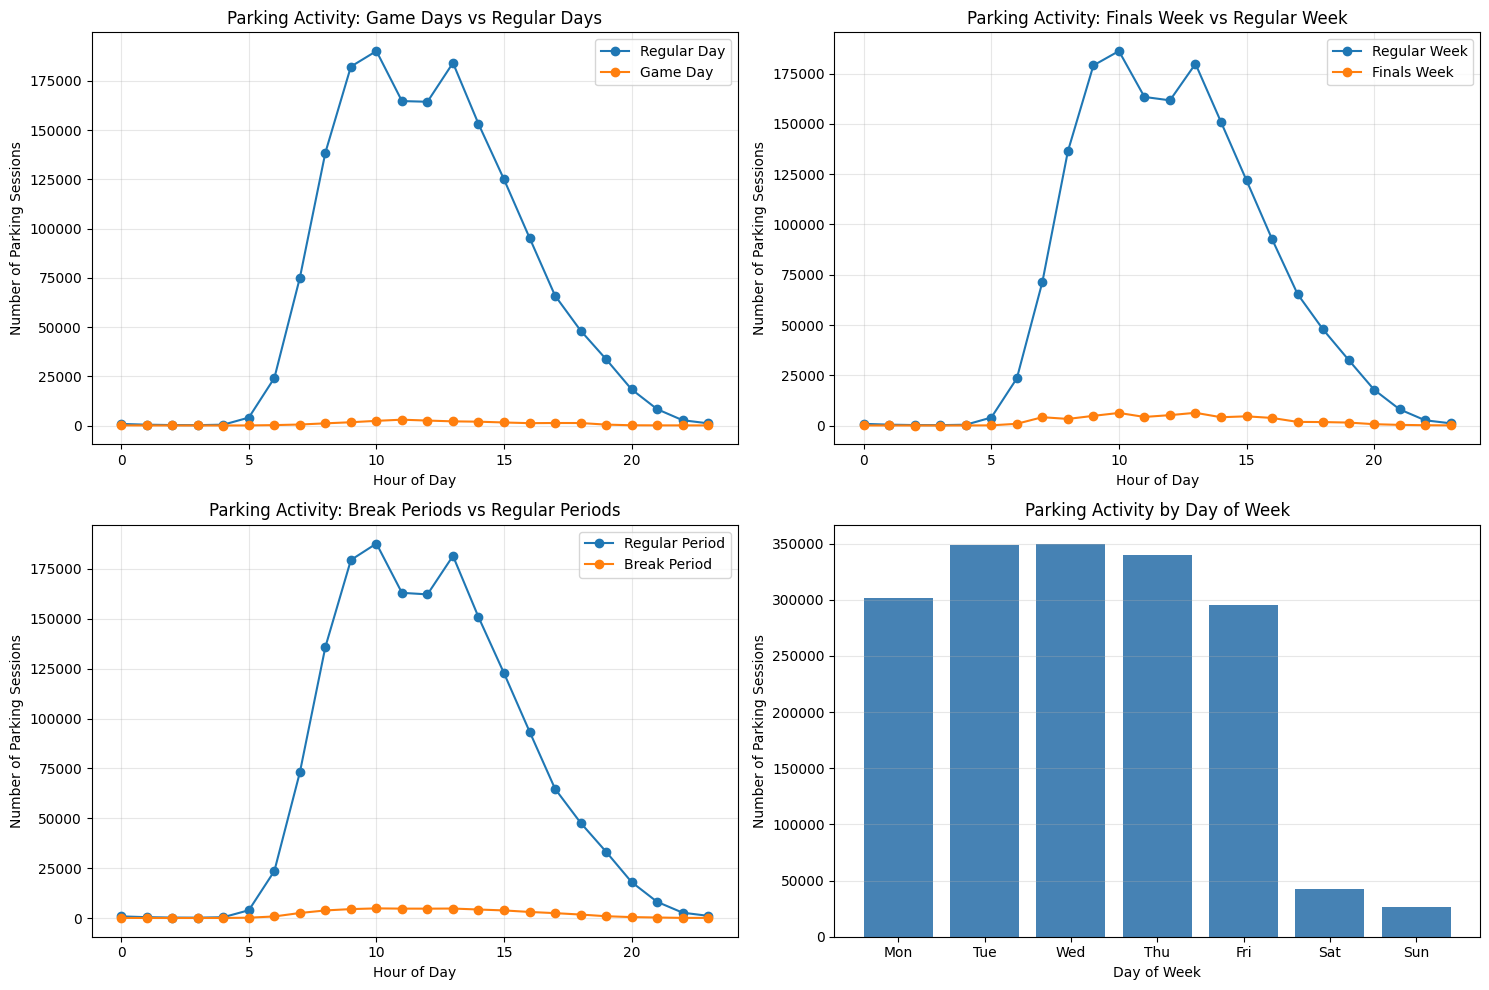

Visualization saved to: data/processed/calendar_impact_visualization.png


In [7]:
# Compare parking activity on different calendar events
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# Game days vs regular days
game_day_hourly = amp_data.groupby(['is_game_day', 'hour']).size().reset_index(name='count')
for is_game in [0, 1]:
    data = game_day_hourly[game_day_hourly['is_game_day'] == is_game]
    label = 'Game Day' if is_game else 'Regular Day'
    axes[0, 0].plot(data['hour'], data['count'], marker='o', label=label)
axes[0, 0].set_title('Parking Activity: Game Days vs Regular Days')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Parking Sessions')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# Finals week vs regular weeks
finals_hourly = amp_data.groupby(['is_finals_week', 'hour']).size().reset_index(name='count')
for is_finals in [0, 1]:
    data = finals_hourly[finals_hourly['is_finals_week'] == is_finals]
    label = 'Finals Week' if is_finals else 'Regular Week'
    axes[0, 1].plot(data['hour'], data['count'], marker='o', label=label)
axes[0, 1].set_title('Parking Activity: Finals Week vs Regular Week')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Number of Parking Sessions')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
# Break periods vs regular days
break_hourly = amp_data.groupby(['is_any_break', 'hour']).size().reset_index(name='count')
for is_break in [0, 1]:
    data = break_hourly[break_hourly['is_any_break'] == is_break]
    label = 'Break Period' if is_break else 'Regular Period'
    axes[1, 0].plot(data['hour'], data['count'], marker='o', label=label)
axes[1, 0].set_title('Parking Activity: Break Periods vs Regular Periods')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Number of Parking Sessions')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
# Day of week comparison
dow_counts = amp_data.groupby('day_of_week').size().reset_index(name='count')
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(range(7), dow_counts['count'], color='steelblue')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)
axes[1, 1].set_title('Parking Activity by Day of Week')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Number of Parking Sessions')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('../data/processed/calendar_impact_visualization.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualization saved to: data/processed/calendar_impact_visualization.png")

## Save Enriched Data

In [8]:
# Save enriched data
amp_data.to_csv('../data/processed/amp_enriched.csv', index=False)
print(f"Enriched data saved: data/processed/amp_enriched.csv")
print(f"  Total records: {len(amp_data):,}")
print(f"  Total columns: {len(amp_data.columns)}")
print(f"\nNew calendar columns added:")
print(f"  {calendar_features}")

Enriched data saved: data/processed/amp_enriched.csv
  Total records: 1,702,867
  Total columns: 24

New calendar columns added:
  ['is_game_day', 'is_game_week', 'days_until_next_game', 'days_since_last_game', 'is_finals_week', 'is_spring_break', 'is_thanksgiving_break', 'is_winter_break', 'is_university_holiday', 'is_any_break']
